# Evaluate / train models

First we import the necessary python modules and set the matplotlib parameters

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import autokeras as ak
from dti_util import tile2im, decode_dam, code_dam, get_score_importances
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import yaml

Set the experiment name and load the experiment setting

In [29]:
# Name of the experiment
name = '4var'

# Root of all directory used
rootdir = '/mnt/sfe-ns9602k/Julien/data'

# Directory of the experiment outputs
expdir = os.path.join(rootdir, name)

# Load experiment parameters
with open(os.path.join(expdir,'data_params.yml' )) as file:
    exp_dict = yaml.load(file, Loader=yaml.FullLoader)
    
# Print experiments parameters
for key, value in exp_dict.items():
    print(key, ' : ', value)
    
# Set the used parameters
traindir = exp_dict['traindir']
epsi = exp_dict['epsi']
th_dam = exp_dict['th_dam']
dsize = exp_dict['dsize']

colnames  :  ('log_deformation_0', 'log_deformation_1', 'c', 'h')
datadir  :  /mnt/sfe-ns9602k/Julien/data/anton/shom5km_defor_4cnn
dsize  :  25
end_train  :  400
epsi  :  0.01
itest  :  1
name  :  4var
othernames  :  ('h',)
rootdir  :  /mnt/sfe-ns9602k/Julien/data
start_train  :  10
strides  :  20
th_dam  :  0.8
th_sit  :  0.9
traindir  :  /mnt/sfe-ns9602k/Julien/data/4var/train


Additional setting for the model

In [30]:

# Name of the model
model_name = "long"
#model_name = "demo"

# Read model setting parameter from file
from_file = False

# pretrained model ( if False, launch a new training)
pretrained = False

# Directory to stores the model
model_dir = os.path.join(expdir, model_name)

# Create the model directory if necessary
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Dictionnary sotring all the mod setting parameters
dmod = dict()

if from_file:
    # Read model parameters from yml file
    with open(os.path.join(model_dir,'model_params.yml' )) as file:
        dmod = yaml.load(file, Loader=yaml.FullLoader)        
else:
    # Create a yml file

    # relative size of the validation dataset
    dmod['test_size'] = 0.15

    # Seed of the train/val random split
    dmod['split_seed'] = 1

    # log_dir for tensorboard
    # log_dir is hardcoded because of NIRD toolkit, how to get the log name automatically?
    dmod['log_dir'] = "/mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/{}-{}".format(name, model_name)

    # Shuffle score file name 
    dmod['fname_score_shuffle'] = 'shuffle_score'

    # Saliency score file name 
    dmod['fname_score_saliency'] = 'saliency_score'

    # Patience of the early stopping
    dmod['patience'] = 20

    # number of epochs
    dmod['epochs'] = 100

    # Number of trials of the model experiment
    dmod['max_trials'] = 50

    # Size of the training set (None for selecting all the training set)
    dmod['ntrain']= None

    # Save the dictionary in yaml format
    with open(os.path.join(model_dir,'model_params.yml'),'w') as file:
        yaml.dump(dmod, file)

        
print ('--- MODEL CONFIGURATION ---')
for key, value in dmod.items():
    print(key, ' : ', value)

--- MODEL CONFIGURATION ---
test_size  :  0.15
split_seed  :  1
log_dir  :  /mnt/sfe-ns9602k/.tools/deep-learn-1603280065-tensorboard/autokeras/4var-long
fname_score_shuffle  :  shuffle_score
fname_score_saliency  :  saliency_score
patience  :  20
epochs  :  100
max_trials  :  50
ntrain  :  None


Define the output normalization/denormalization

In [4]:
# Normalization function
norm = lambda x : code_dam(x,epsi=epsi, vmin=th_dam)

# Denormalization function
denorm = lambda x : decode_dam(x,epsi=epsi, vmin=th_dam)

In [5]:
# Plot options

In [6]:
lims = {
    'log_deformation_0': (-4, 1),
    'damage_n' : [norm(1),norm(th_dam)],
    'damage' : [th_dam, 1]

}

## 1. Load datasets

In [7]:
data = np.load(os.path.join(traindir,'train.npz'))
X = data['Xtrain']
y = data['ytrain']
mask_train = data['mask_train']
yd = denorm(y)

In [8]:
print(f"Number of training samples: {X.shape[0]}")
print(f'Size of input feature: {X.shape[1:]}')

Number of training samples: 104640
Size of input feature: (25, 25, 4)


Split the training set into train and validation

In [9]:
Xtrain, Xval, ytrain, yval = train_test_split(X.astype(np.float32), y.astype(np.float32),
                                                    test_size = dmod['test_size'],
                                                    random_state = dmod['split_seed'])

print(f"Number of training samples: {X.shape[0]}")
print(f"Number of validation samples: {X.shape[0]}")


Number of training samples: 104640
Number of validation samples: 104640


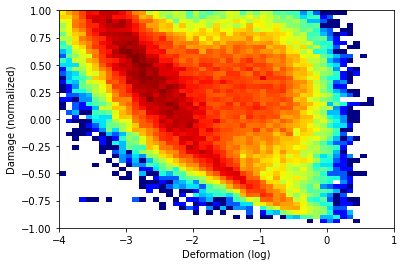

In [10]:
fig, ax = plt.subplots()
xx = Xtrain[:,dsize//2,dsize//2,0].ravel()
yy = ytrain.ravel()

ax.hist2d(xx,yy,  50, [lims['log_deformation_0'],lims['damage_n'] ], norm=matplotlib.colors.LogNorm(), cmap='jet');
ax.set_xlabel('Deformation (log)')
ax.set_ylabel('Damage (normalized)');

## 2. Baseline

Two baseline are defined. Anton baselinee: ```reg_ak``` and Julien baseline: ```reg_jb```
Both baseline take the collocated deformation (scalar variable) as a predictor for the damage.
Julien's baseline is based on a polynomail regression of degree 2 based on hand-made points

In [11]:
def reg_ak(dd):
    return np.clip(1.01 - 0.008/(10**dd)**0.3,0,1)

xpoint = np.array([-3, -2.5, -2, -1.5, -1,  0])
ypoint = np.array([.72, .25, -0.2, -.5, -0.7, -0.85])
coef = np.polyfit(xpoint, ypoint, 2)
print (f'Coefficients of the polynomial fit: {coef}')

def reg_jb(x):
    y = np.poly1d(coef)(x)
    lim = -coef[1]/(2*coef[0])
    y[x>lim] = np.poly1d(coef)(lim)
    y[x<-3.2] = np.poly1d(coef)(-3.2)
    return denorm(y)



Coefficients of the polynomial fit: [ 0.19285714  0.05257143 -0.84892857]


Compute the predictions by the two baselines for regular spaced deformation

In [12]:
xlin = np.linspace(lims['log_deformation_0'][0],lims['log_deformation_0'][1],100)

y_ak_lin = reg_ak(xlin)
y_jb_lin = reg_jb(xlin)

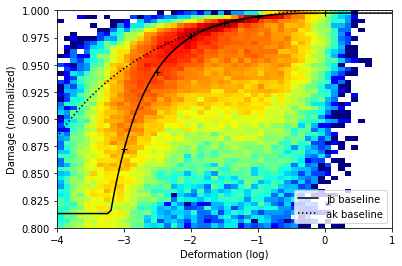

In [13]:
fig, ax = plt.subplots()
xx = Xtrain[:,dsize//2,dsize//2,0].ravel()
yy = denorm(ytrain).ravel()

ax.hist2d(xx,yy,  50, [lims['log_deformation_0'],lims['damage'] ], norm=matplotlib.colors.LogNorm(), cmap='jet');
ax.set_xlabel('Deformation (log)')
ax.set_ylabel('Damage (normalized)');

ax.plot(xpoint,denorm(ypoint),'+k')
ax.plot(xlin,y_jb_lin,'-k',label="jb baseline")
ax.plot(xlin,y_ak_lin,':k',label="ak baseline")

ax.legend(loc='lower right')

## 3. Load/train model

In [14]:
if pretrained:
    model = load_model(os.path.join(model_dir,model_name))
else:
    input_node = ak.ImageInput()
    out_node = ak.Normalization()(input_node)
    out_node = ak.ConvBlock()(out_node)
    #out_node2 = ak.XceptionBlock()(out_node)
    #out_node3 = ak.ResNetBlock()(out_node)
    #out_node = ak.Merge()([out_node1, out_node2, out_node3])
    output_node = ak.RegressionHead()(out_node)


    output_node = ak.RegressionHead()(out_node)
    reg  = ak.AutoModel(
        inputs=input_node, outputs=output_node, 
        overwrite=True, 
        max_trials=dmod['max_trials'],
        project_name = 'reg',
        directory=model_dir
    )
    
    
    tensorboard_callback= tf.keras.callbacks.TensorBoard(log_dir=dmod['log_dir'], histogram_freq=2)
    
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=dmod['patience'],
    min_delta=1e-4,
    verbose=1,
    restore_best_weights=True
)
    
    reg.fit(
        Xtrain[:dmod['ntrain']],
        ytrain[:dmod['ntrain']],
        validation_data=(Xval, yval),
        epochs = dmod['epochs'],
        callbacks=[tensorboard_callback, early_stopping_monitor]
        )
    model = reg.export_model()
    model.save(os.path.join(model_dir,model_name), save_format="tf")

Trial 3 Complete [00h 00m 53s]
val_loss: 0.12229651212692261

Best val_loss So Far: 0.12229651212692261
Total elapsed time: 00h 01m 59s
INFO:tensorflow:Oracle triggered exit
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /mnt/sfe-ns9602k/Julien/data/4var/demo/reg/best_model/assets
INFO:tensorflow:Assets written to: /mnt/sfe-ns9602k/Julien/data/4var/demo/demo/assets


In [15]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 4)]       0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 25, 25, 4)         0         
_________________________________________________________________
normalization (Normalization (None, 25, 25, 4)         9         
_________________________________________________________________
conv2d (Conv2D)              (None, 23, 23, 32)        1184      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 32)       

In [16]:

model.evaluate(Xval, yval, batch_size=20)


785/785 [==============================] - 2s 2ms/step - loss: 0.1223 - mean_squared_error: 0.1223


[0.12229667603969574, 0.12229667603969574]

In [17]:
ypredict = denorm(model.predict(Xval))


In [18]:

y_ak = reg_ak(Xval[:,dsize//2,dsize//2,0])
y_jb = reg_jb(Xval[:,dsize//2,dsize//2,0])

In [19]:
import seaborn as sns

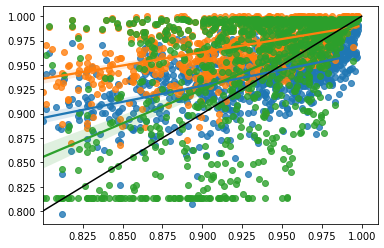

In [20]:
sns.regplot(denorm(yval[:1000]),ypredict[:1000])
sns.regplot(denorm(yval[:1000]),y_ak[:1000])
sns.regplot(denorm(yval[:1000]),y_jb[:1000])
plt.plot([.8, 1], [.8, 1], 'k')

In [21]:
rmse_ak = np.sqrt(np.mean(np.square(denorm(yval[:1000]) - y_ak[:1000])))
rmse_jb = np.sqrt(np.mean(np.square(denorm(yval[:1000]) - y_jb[:1000])))
rmse_pred = np.sqrt(np.mean(np.square(denorm(yval[:1000]) - ypredict[:1000])))
print(f'RMSE ak: {rmse_ak}\nRMSE jb: {rmse_jb}\nRMSE NN: {rmse_pred}')

RMSE ak: 0.055311888456344604
RMSE jb: 0.05333523824810982
RMSE NN: 0.053756073117256165


In [22]:
corr_ak = np.corrcoef(denorm(yval[:1000]),y_ak[:1000])[0,1]
corr_jb = np.corrcoef(denorm(yval[:1000]),y_jb[:1000])[0,1]
corr_pred = np.corrcoef(denorm(yval[:1000]),ypredict[:1000,0])[0,1]

print(f'corr ak: {corr_ak}\ncorr jb: {corr_jb}\ncorr NN: {corr_pred}')

corr ak: 0.526247732996351
corr jb: 0.5392561784767095
corr NN: 0.5491283462503587


NameError: name 'yreg' is not defined

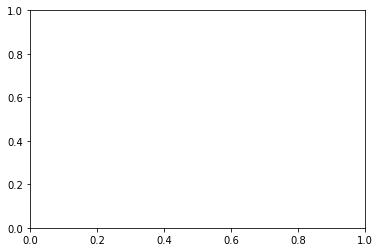

In [24]:
fig, ax = plt.subplots()

sns.regplot(denorm(yval[:1000]),yreg[:1000],color='C1',ax=ax, label="simple regression")
sns.regplot(denorm(yval[:1000]),ypredict[:1000],color='C2',ax=ax, label="CNN")
ax.set_xlim((.85,1.01))
ax.set_ylim((.85,1.01))
ax.plot((.85,1.01),(.85,1.01),':k')
ax.legend()

NameError: name 'yreg' is not defined

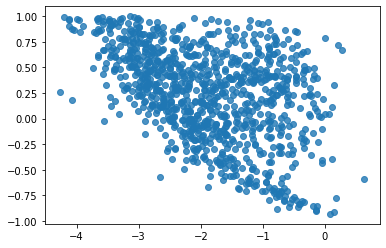

In [25]:
sns.regplot(Xval[:1000,12,12],yval[:1000],fit_reg=False, label='data')
sns.regplot(Xval[:1000,12,12],norm(yreg[:1000]),fit_reg=False, label= 'simple reg')
sns.regplot(Xval[:1000,12,12],norm(ypredict[:1000]),fit_reg=False, label = 'CNN')
plt.legend()

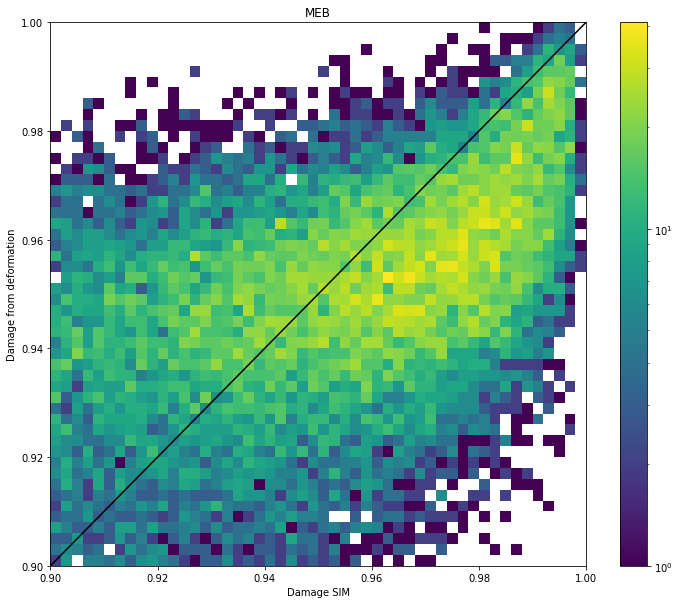

In [58]:
lims = [0.9, 1]
plt.figure(figsize=(12,10))
plt.hist2d(denorm(yval.ravel()),ypredict.ravel(),  50, [lims, lims], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot(lims, lims, 'k-')
plt.ylabel('Damage from deformation')
plt.xlabel('Damage SIM')
plt.title('MEB')
plt.show()

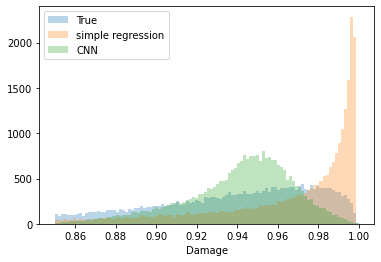

In [59]:
bins = 100

dd = denorm(yval.ravel())
lims = [.85, 1]

plt.hist(dd, bins,  lims, alpha=0.3, label='True')
plt.hist(y_jb.ravel(), bins,  lims, alpha=0.3, label='simple regression')
plt.hist(ypredict.ravel(), bins,  lims, alpha=0.3, label='CNN')

plt.xlabel('Damage')
plt.legend()

In [60]:
path_score = os.path.join(model_dir, fname_score_shuffle + '.npz')

n, nim1, nim2, nc = Xval[:500].shape
X_sk = Xval[:500].reshape((n,-1)) 
y_sk = denorm(yval[:500])
def score_nn (X, y):
    Xtmp = X.reshape((n,nim1,nim2,nc))
    ypredict = denorm(model.predict(Xtmp))
    return np.sqrt(np.mean(np.square(y[~np.isnan(y)] - ypredict[~np.isnan(y)])))
#score_nn(X_sk,denorm(yval))
base_score, score_decreases = get_score_importances(score_nn, 
                                                    X_sk, 
                                                    y_sk, 
                                                    n_iter=3, 
                                                    pre_shuffle=True
                                                   )
score_mean = np.mean(score_decreases, axis=0).reshape(nim1,nim2,nc)

np.savez(path_score, base_score=base_score, score_decreases=scores_decreasesm score_mean = score_mean)

preshuffle
preshuffle
preshuffle


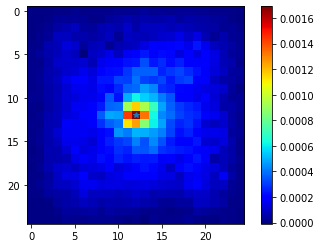

In [82]:
path_score = os.path.join(model_dir, fname_score_shuffle + '.npz')
score_mean = np.mean(score_decreases, axis=0).reshape(nim1,nim2,nc)
np.savez(path_score, base_score=base_score, score_mean = score_mean)

plt.imshow(score_mean[...,0],cmap='jet')
plt.plot(12,12,'*')
plt.colorbar()

In [23]:
from tf_keras_vis.saliency import Saliency
saliency = Saliency(model,
                    model_modifier=None,
                    clone=False)

In [26]:
isal = [0,1,2,100]

def loss(output):
    return tuple(output[i] for i in range(100))
saliency_map = saliency(loss, Xval[:100])

print(saliency_map.shape)
saliency_absmean = np.abs(saliency_map).mean(axis=0)

(100, 25, 25)


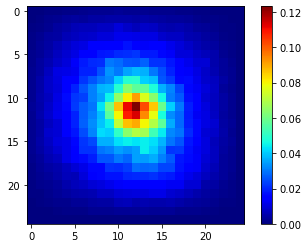

In [25]:
plt.imshow(saliency_absmean, cmap='jet')
plt.colorbar()

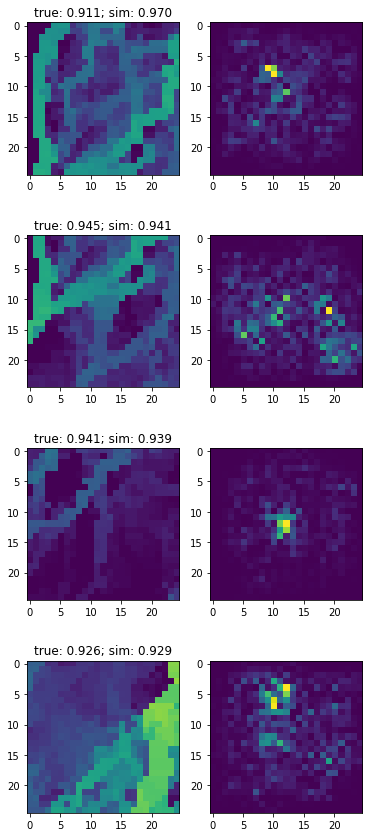

In [125]:
fig, ax = plt.subplots(nrows=4,ncols=2, figsize=(6,15))
for i in range(4):
    ax[i,0].imshow(X[isal[i]],vmin=lims['log_deformation_0'][0], vmax=lims['log_deformation_0'][1])
    ax[i,0].set_title(f'true: {denorm(yval[isal[i]]):.3f}; sim: {ypredict[isal[i],0]:.3f}')
    ax[i,1].imshow(np.abs(saliency_map[i]))

#plt.imshow(saliency_map.squeeze())

In [115]:
ypredict[isal[i],0]

0.9702786

In [62]:
data_test = np.load(os.path.join(traindir,'test.npz'))

In [64]:
Xtest = data_test['Xtest']
ytest = denorm(data_test['ytest'])
mask_test = data_test['mask_test']
shape_original = data_test['shape_original']
print (Xtest.shape,mask_train.shape[0], shape_original)

(154298, 25, 25, 1) 324480 [  1 400 500]


In [65]:
def tile2im(X1,y1,slic=1,ny=400,nx=500):
    dsize = X1.shape[1]
    nrows = (ny-dsize)//slic + 1
    ncols = (nx-dsize)//slic +1
    nn = X1.shape[0]//(nrows*ncols)
    nc = X1.shape[-1]
    X2 = np.empty((nn,ny,nx,nc))
    y2 = np.zeros((nn,ny,nx,1))
    print(nn,nrows,ncols)
    k=0
    for im in range(nn):
        for ix in range(ncols):
            for iy in range(nrows):
                X2[im,iy*slic:iy*slic+dsize,ix*slic:ix*slic+dsize,:]=X1[k,:,:,:]
                y2[im,iy*slic+dsize//2,ix*slic+dsize//2,:]=y1[k,:]
                k=k+1
    return X2, y2

In [66]:
nn = mask_test.shape[0]
ny = shape_original[1]
nx = shape_original[2]
nc = Xtest.shape[-1]
ntile = Xtest.shape[1]
print(nn,ny,nx,nc)
X1 = np.nan * np.ones((nn,ntile,ntile,nc))
y1 = np.nan * np.ones((nn,1))
y1_predict = np.nan * np.ones((nn,1))
y1_reg = np.nan * np.ones((nn,1))
print(ytest.shape)


178976 400 500 1
(154298,)


In [71]:
X1[mask_test]=Xtest
y1[mask_test,0]=ytest
y1_reg[mask_test,0]=reg_jb(Xtest[:,12,12,0])
y1_predict[mask_test] = denorm(model.predict(Xtest))

In [72]:
X2_test, y2_test, = tile2im(X1,y1, slic= 1, ny=shape_original[1], nx=shape_original[2])
X2_predict, y2_reg = tile2im(X1,y1_reg, slic= 1, ny=shape_original[1], nx=shape_original[2])
X2_predict, y2_predict = tile2im(X1,y1_predict, slic= 1, ny=shape_original[1], nx=shape_original[2])

1 376 476
1 376 476
1 376 476


In [75]:
yytest = y2_test[0,...,0]
yytest[yytest<.85]=np.nan

yyreg = y2_reg[0,...,0]
yyreg[np.isnan(yytest)]=np.nan

yypred = y2_predict[0,...,0]
yypred[np.isnan(yytest)]=np.nan


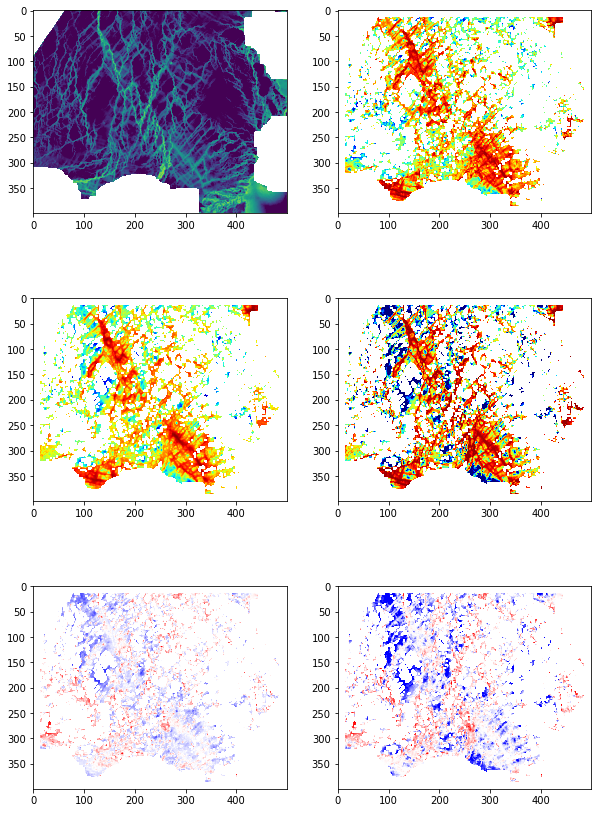

In [76]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(10,15))
ax[0,0].imshow(X2_test[0,...,0],vmin=-3,vmax=1)
ax[0,1].imshow(yytest,vmin=0.85, vmax=1,cmap='jet')
ax[1,0].imshow(yypred,vmin=0.85, vmax=1,cmap='jet')
ax[1,1].imshow(yyreg,vmin=0.85, vmax=1,cmap='jet')
ax[2,0].imshow(yypred-yytest,vmin=-0.1,vmax=0.1,cmap=plt.get_cmap('bwr'))
ax[2,1].imshow(yyreg-yytest,vmin=-0.1,vmax=0.1,cmap=plt.get_cmap('bwr'))

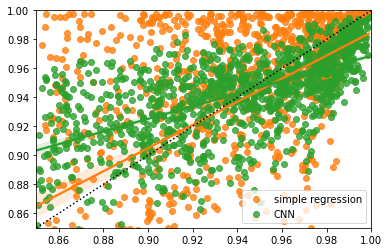

In [77]:
fig, ax = plt.subplots()
sns.regplot(yytest[~np.isnan(yytest)][::100],yyreg[~np.isnan(yytest)][::100],ax=ax,color='C1',label="simple regression")
sns.regplot(yytest[~np.isnan(yytest)][::100],yypred[~np.isnan(yytest)][::100],ax=ax,color='C2',label='CNN')
ax.set_xlim((.85,1))
ax.set_ylim((.85,1))
ax.plot((.85,1.01),(.85,1.01),':k')
ax.legend()

In [78]:
rmse_reg = np.sqrt(np.mean(np.square(yytest[~np.isnan(yytest)] - yyreg[~np.isnan(yytest)])))
rmse_pred = np.sqrt(np.mean(np.square(yytest[~np.isnan(yytest)] - yypred[~np.isnan(yytest)])))
print(f'RMSE Reg: {rmse_reg}\nRMSE NN: {rmse_pred}')

RMSE Reg: 0.052511860487327935
RMSE NN: 0.03182632664154626


In [79]:
corr_reg = np.corrcoef(yytest[~np.isnan(yytest)],yyreg[~np.isnan(yytest)])[0,1]
corr_pred = np.corrcoef(yytest[~np.isnan(yytest)],yypred[~np.isnan(yytest)])[0,1]
print(f'corr Reg: {corr_reg}\ncorr NN: {corr_pred}')

corr Reg: 0.5494005776410897
corr NN: 0.6159508047179647


In [26]:
lims = [0.86, 1]
plt.figure(figsize=(12,10))
plt.hist2d(yytest.ravel(),yyreg.ravel(),  50, [lims, lims], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot(lims, lims, 'k-')
plt.ylabel('Damage from deformation')
plt.xlabel('Damage SIM')
plt.title('MEB')
plt.show()

NameError: name 'yytest' is not defined

<Figure size 864x720 with 0 Axes>

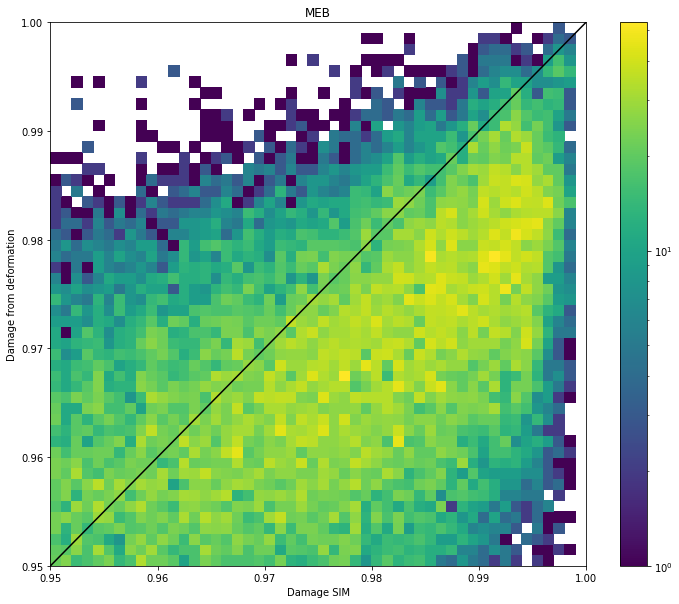

In [66]:
lims = [0.95, 1]
plt.figure(figsize=(12,10))
plt.hist2d(yytest.ravel(),yypred.ravel(),  50, [lims, lims], norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.plot(lims, lims, 'k-')
plt.ylabel('Damage from deformation')
plt.xlabel('Damage SIM')
plt.title('MEB')
plt.show()

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 106 kB 3.0 MB/s eta 0:00:01


In [157]:
#TODO extract parameters from best model (optimizer, batch_size?)

model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4), loss='mean_squared_error')
#model.fit(Xval)
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)
history = model.fit(
    Xtrain,
    ytrain,
    validation_data=(Xval, yval),
    epochs = 50,
    callbacks=[early_stopping_monitor]
)
model.save(os.path.join(model_dir,model_name), save_format="tf")


Epoch 1/50
 682/4940 [===>..........................] - ETA: 11s - loss: 0.1383

KeyboardInterrupt: 